# <h1><center>Produce Classification using Tensorflow</center></h1>

![Banner](figures/banner.png)

## Table of Contents
1. [Business Problem](#1)
2. [Data Analysis](#2)
3. [Modeling](#3)
4. [Analyzing Loss](#4)
5. [Recommendations](#5)

### <a name="1">Business Problem</a>

Having reliable access to fresh produce is one of the most important selling points for grocery stores.Knowing this, I have been tasked by a local green grocer, Four Corners Marketplace, to implement a system that can quickly and accurately identify different produce. This will increase both the quality of produce being shipped in, as well as potentially speeding up the self-checkout experience, which will in turn increase customer turnaround.

### <a name="2">Data Analysis</a>

ALL DATA SOURCED FROM: https://www.kaggle.com/datasets/moltean/fruits

I utilized data sourced from the Fruits 360 datset on Kaggle (linked above). This contained over 65,000 images of fruits and vegetables in 131 different classes for identification. Because the data was pre split, I decided to use Keras' own preprocessing techniques to do a split of my own on their training folder. Preparing the images required me to convert them into Arrays of numbers that Tensorflow can then interpret and make predictions based off of.

In [1]:
# Basic imports
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
image_height, image_width = 180,180
batches = 32

# creating variables of our respective image datasets
train_img = tf.keras.preprocessing.image_dataset_from_directory(
    './produce_imgs',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(image_height, image_width),
    batch_size=batches
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [3]:
val_img = tf.keras.preprocessing.image_dataset_from_directory(
    './produce_imgs',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(image_height, image_width),
    batch_size=batches
)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [4]:
classes = train_img.class_names

Here is a little function to show some examples from our set.

In [5]:
def show_examples(img_df):
    plt.figure(figsize=(10,10))
    for images, labels in img_df.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(classes[labels[i]])
            plt.axis('off')

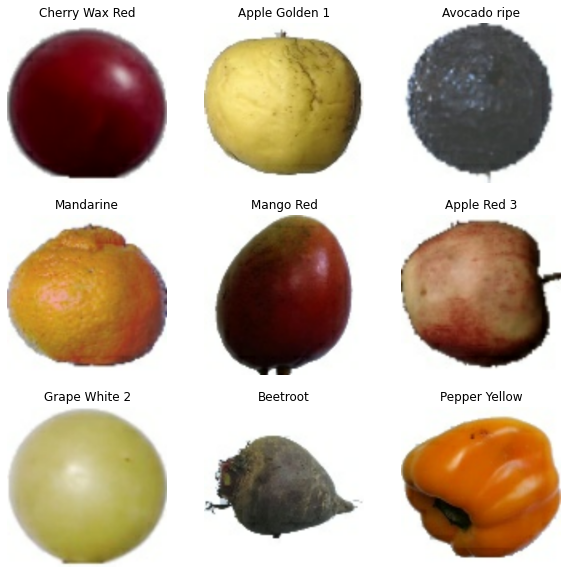

In [6]:
show_examples(train_img)

Wonderful! As we can see our data has been loaded successfully. Now we can move on to creating a baseline model.

### <a name="3">Modeling</a>

For my first base model, I wanted to put in the bare minimum to see how everything performed with no modifications.

In [7]:
# this needs to be relative to the amount of classes that are being used
softmax_layers = len(classes)

In [8]:
# using Keras' Sequential function I can create custom CNN layers and add or remove complexity as I like

base_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, (4,4), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(softmax_layers, activation=tf.nn.softmax)
])

In [9]:
base_model.compile(optimizer='adam', 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy']) 

In [10]:
base_model_fit = base_model.fit(train_img, 
                                  epochs=1,
                                  validation_data=val_img, 
                                  shuffle=True)

1693/1693 [==============================] - 254s 150ms/step - loss: 0.3217 - accuracy: 0.9276 - val_loss: 0.0491 - val_accuracy: 0.9920


Thanks to the sheer size of our data, even our base model has an impressive accuracy score.

In [11]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, (4,4), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Conv2D(32, (4,4), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(softmax_layers, activation=tf.nn.softmax)
])

In [12]:
model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [13]:
model_1_fit = model_1.fit(train_img, 
                                  epochs=1,
                                  validation_data=val_img, 
                                  shuffle=True)

1693/1693 [==============================] - 315s 186ms/step - loss: 0.3222 - accuracy: 0.9239 - val_loss: 0.0231 - val_accuracy: 0.9938


We can see our values were almost the same. Now we can try reducing window size by 2 to see if we are heading in the right direction.

In [14]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, (2,2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (2,2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(softmax_layers, activation=tf.nn.softmax)
])

In [15]:
model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [16]:
model_2_fit = model_2.fit(train_img, 
                                  epochs=1, 
                                  validation_data=val_img, 
                                  shuffle=True)

1693/1693 [==============================] - 400s 236ms/step - loss: 0.2861 - accuracy: 0.9399 - val_loss: 0.1058 - val_accuracy: 0.9747


We see here it actually lowers our validation performance. For our final model let's try instead adding an addition set of Conv2D and Pooling layers with our previous window size of 4, 4.

In [17]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(16, (4,4), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Conv2D(32, (4,4), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Conv2D(64, (4,4), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(4,4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(softmax_layers, activation=tf.nn.softmax)
])

In [18]:
model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [19]:
model_3_fit = model_3.fit(train_img, 
                                  epochs=3, 
                                  validation_data=val_img, 
                                  shuffle=True)

Epoch 1/3
1693/1693 [==============================] - 313s 185ms/step - loss: 0.6195 - accuracy: 0.8398 - val_loss: 0.0422 - val_accuracy: 0.9888
Epoch 2/3
1693/1693 [==============================] - 308s 182ms/step - loss: 0.0589 - accuracy: 0.9826 - val_loss: 0.0132 - val_accuracy: 0.9973
Epoch 3/3
1693/1693 [==============================] - 320s 189ms/step - loss: 0.0318 - accuracy: 0.9913 - val_loss: 0.0449 - val_accuracy: 0.9856


Fantastic! I managed to achieve over 99% accuracy for our test and 98.5% accuracy for our validation. Thanks to our utilization of the larger window size, we were able to achieve both faster computation and better performance.

### <a name="4">Analyzing Loss</a>

Now we need to compare our train loss/accuracy to our validation.

In [24]:
def plot_loss(model):
    
    fig = plt.figure(figsize=(13, 7))
    
    # plotting our accuracy
    plt.subplot(221)
    plt.plot(model.history['accuracy'],'bo--', label='accuracy')
    plt.plot(model.history['val_accuracy'],'ro--', label='validation accuracy')
    plt.title('accuracy vs. validation accuracy')
    plt.xlabel('# of epochs')
    plt.ylabel('accuracy')
    plt.legend()
    
    # plotting our loss
    plt.subplot(222)
    plt.plot(model.history['loss'],'bo--', label='loss')
    plt.plot(model.history['val_loss'],'ro--', label='validation loss')
    plt.title('loss vs. validation loss')
    plt.xlabel('# of epochs')
    plt.ylabel('loss')
    plt.legend()
    
    plt.show()

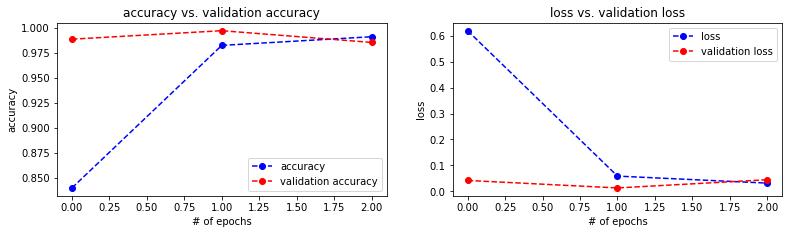

In [25]:
plot_loss(model_3_fit)

It looks like our values cross right before where our final model is cut off, which is exactly where we want to be. I am confident that this model would be able to help grocery stores to identify produce quickly and efficiently, allowing more customer turnaround and thus more profit.

### <a name="5">Recommendations</a>

- Implement my model to accurately predict different fruit and vegetables and increase customer turnaround.
- Set up scanners at the warehouse to check incoming produce for mold/rot.
- Set up a custom list of produce to create a more personalized classification system.